## Value-At-Risk: Mixture of Gaussian Distributions

note:  consider to split it into data preparation to check for:
- normality
- stationarity
- serial correlation


1. Check series for normality
2. Construct the Gaussian VaR model
3. Construct  the two component Gaussian mixture VaR model
4. Select the number of components in the Gaussian mixture
5. Asses the performance of the model

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks'])
# plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 10.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.tight_layout()
%matplotlib inline


from sklearn.mixture import GaussianMixture
from scipy.optimize import newton
from scipy.stats import norm

import pandas_datareader.data as ds

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
from common.utils import groupby_subplot
from analytics.financials.utils import nday_return
from analytics.mlearn.utils import select_n_components


def gmm_mixture():
    def f(n_components):
        return GaussianMixture(n_components, covariance_type='full', random_state=0)

## Parameters of the Model

In [4]:
import sys

sys.path

['',
 '/home/batu/work/repos',
 '/home/batu/anaconda3/lib/python36.zip',
 '/home/batu/anaconda3/lib/python3.6',
 '/home/batu/anaconda3/lib/python3.6/lib-dynload',
 '/home/batu/anaconda3/lib/python3.6/site-packages',
 '/home/batu/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/batu/.ipython']

- estimation window 750 days
- holding period or risk horizon  1 day
- backtesting window 50 days

In [7]:
# estimation window
est_window = 250
# risk horizon/holding period
nday = 3
start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2017-12-31')

### Load Market Data

In [8]:
df_y = ds.DataReader('AAPL', 'iex', start, end)['close']

5y


### Construct log-return series

In [9]:
df = pd.DataFrame({'level': df_y.iloc[nday:],
                   'logrtn': nday_return(df_y, nday=nday, log=True).iloc[nday:]})
N = df.shape[0]
df['grp'] = list(map(lambda x: int(x/est_window)  - 1 * (x % est_window == 0), list(range(1, N + 1))))
##df_grouped = df.groupby(df.index.year)
df_grouped = df.groupby('grp')
nyear = df_grouped.ngroups
df_grouped['logrtn'].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
0,250.0,0.002126,0.029177,-0.096655,-0.013591,0.002459,0.019623,0.092517
1,250.0,0.006347,0.024469,-0.057336,-0.009264,0.007188,0.020245,0.124110
2,250.0,-0.002262,0.028104,-0.109125,-0.016404,-0.001532,0.015064,0.090786
3,250.0,0.003835,0.024184,-0.107225,-0.007815,0.003694,0.015356,0.091735
4,203.0,0.003173,0.019892,-0.066183,-0.007846,0.003277,0.014913,0.071282


### Check for normality

A normality assumption, which is common among practitioners while modeling returns, is often advocated due to it simplicity and comfort in computations. Although, the normality assumption might hold for some periods in the return series, it is often violated. To see this let's plot quantile plot to compare log return distribution to that of Normal distribution for each year.

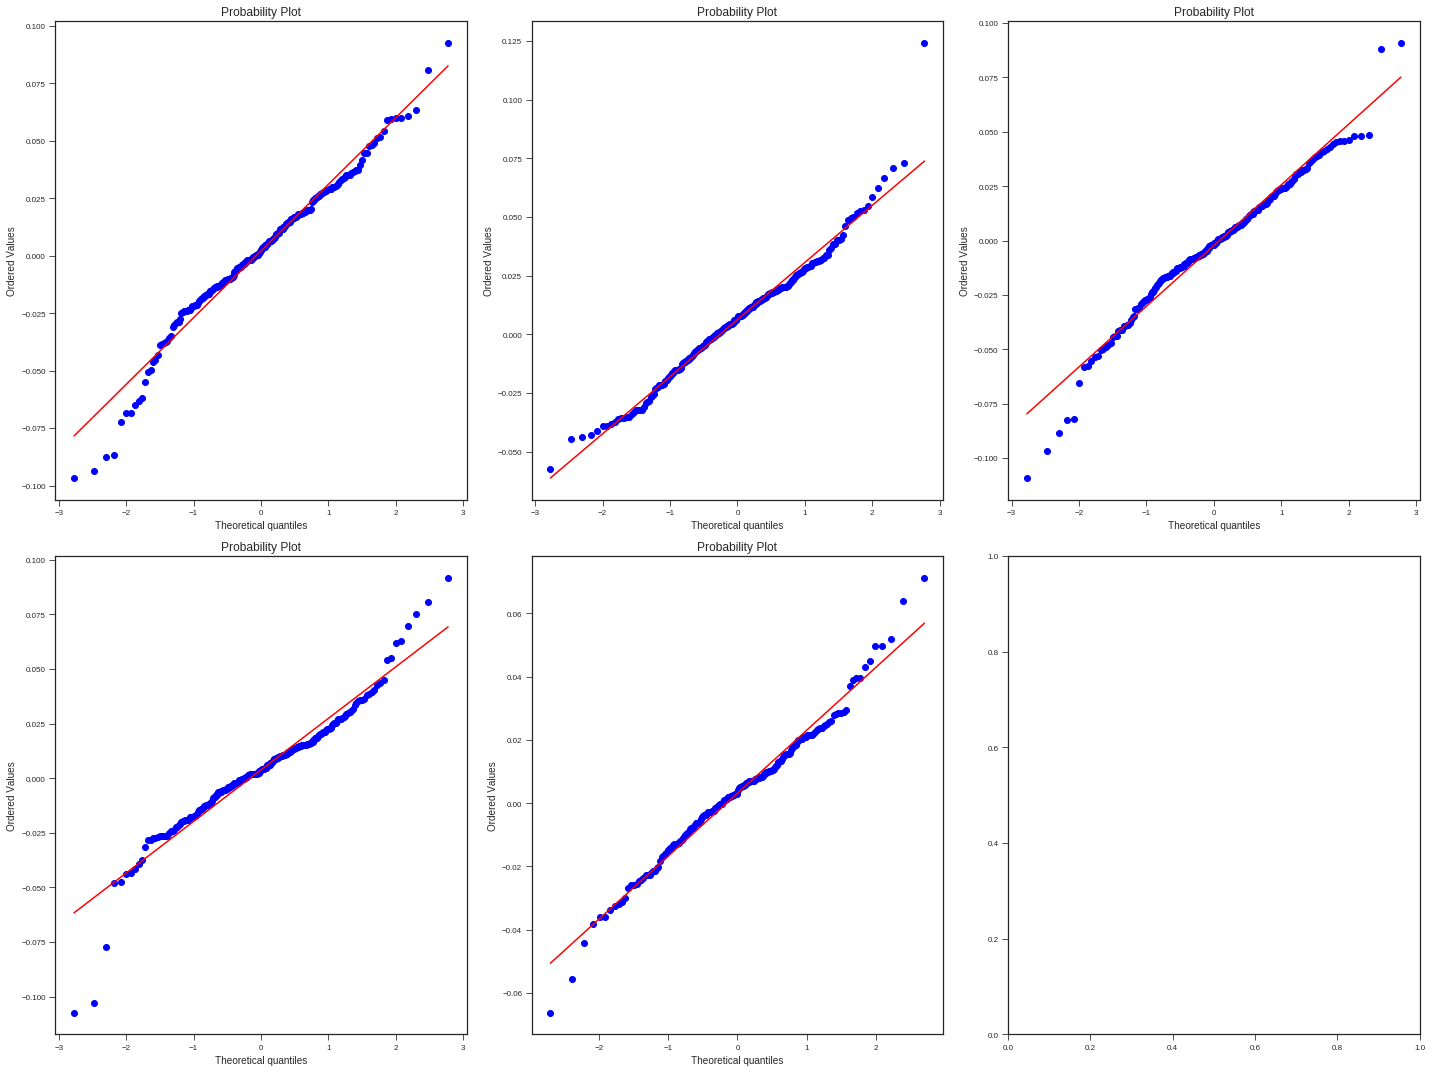

In [10]:
groupby_subplot(df_grouped, columns='logrtn', plot=lambda x: stats.probplot(x, dist="norm", plot=plt), ncol=3, figsize=(20,15), ticksize=(8,8))

In [8]:
# check for serial correlation
# subplot_groups(df_grouped, columns=['logrtn', 'logrtn_lag'], plot=scatter_plot, ncol=4, figsize=(20,15), ticksize=(8,8))

### Gaussian Mixture Model

In [34]:
bktest_window = 250*3
total_nofobs = bktest_window + est_window
n = df.shape[0]
data = df[['logrtn','level']].values[n - total_nofobs:n]

In [35]:
today = data.shape[0] -1
p_today = data[today, 1]
p_lagged = data[today - nday, 1]
X = data[today - nday - est_window:today - nday, 0, None]
assert(abs(np.log(p_today/p_lagged) - data[today,0]) < 10**(-6))

#### Select the Number of Mixture Components

In [46]:
gmm = GaussianMixture
maxcomp = 21
n_components_bic, n_components_aic, m_bic, m_aic = select_n_components(X, mixture=gmm, maxcomp=21)

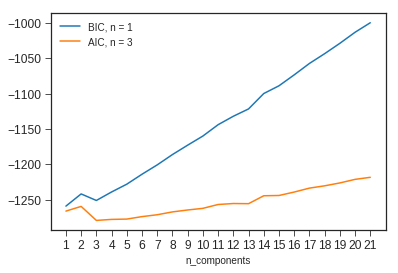

In [47]:
n_components = np.arange(1, maxcomp + 1)
plt.plot(n_components, m_bic, label='BIC, n = {}'.format(n_components_bic))
plt.plot(n_components, m_aic, label='AIC, n = {}'.format(n_components_aic))
plt.legend(loc='best');
plt.xlabel('n_components');
ax = plt.gca();
ax.set_xticks(n_components);

In [48]:
gmm = GaussianMixture(n_components=n_components_aic)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [49]:
print(gmm.means_.flatten())
print(gmm.covariances_.flatten())
print(gmm.weights_)

[ 0.0471559  -0.01016294  0.00776114]
[ 0.00018271  0.0003521   0.00012254]
[ 0.05902653  0.28153159  0.65944188]


In [50]:
# backtesting - start
def simple_normal_model(X):
    # simple normal density estimation
    d = norm(X.mean(), X.std())
    def sample(n):
        return [d.rvs(n)]
    simple_normal_model.sample = sample
    return simple_normal_model


def gmm_model_aic(X):
    # select the number components in the Gaussian mixture model
    n_components = np.arange(1,6)
    n_components_bic, n_components_aic, m_bic, m_aic = select_n_components(X, n_components=n_components)
    
    # fit the model
    gmm = GaussianMixture(n_components=n_components_aic)
    gmm.fit(X)
    
    return gmm


def gmm_model_bic(X):
    # select the number components in the Gaussian mixture model
    n_components = np.arange(1,6)
    n_components_bic, n_components_aic, m_bic, m_aic = select_n_components(X, n_components=n_components)
    
    # fit the model
    gmm = GaussianMixture(n_components=n_components_bic)
    gmm.fit(X)
    
    return gmm


def bootstraped_values(data, model):
    n = data.shape[0]
    p_lagged = data[n - 1, 1]
    nsmaple = 1000
    VaR_r = np.array([np.percentile(model.sample(nsmaple)[0], alpha * 100) for k in range(200)]).mean()
    return p_lagged * (np.exp(-VaR_r) - 1)
                       

def estimated_VaR(data, model, today, alpha):
    X = data[:, 0, None]
    
    # fit Gaussian Mixture Model
    m = model(X)
    
    # estimate the quantile with confidence level alpha
    n = 1000
    VaR = bootstraped_values(data, m)
    
    return VaR


def true_PnL(data, today, nday):
    PnL =  np.subtract(data[today, 1], data[today - nday, 1])
    return PnL


def backtest(data, window, models, nday, true_value, expected_value,  **kwarg):
    """
    Parameter
    ---------
    model: function reference to estimation model 
    """
    
    def _get_data(nday):
        def f(data, today):
            _data = data[today - nday + 1 - est_window:today - nday + 1]
            return _data
        return f
    
    get_data = _get_data(nday)
    
    n = data.shape[0]
    bktest = np.arange(n - window, n)
    
    true_values = [list(true_loss(data, bktest, nday))]
    expected_values = [[expected_value(get_data(data, today), model, today, **kwarg) for today in bktest] for model in models]
    vals = true_values + expected_values
    vals = np.array(vals)
    return vals

# backtesting - end

In [51]:
alpha = 0.995
bw = 300
vals = backtest(data, window=bw, models=[simple_normal_model, gmm_model_aic, gmm_model_bic], true_value=true_loss, expected_value=estimated_VaR, nday=nday, alpha=alpha)
plt.figure(figsize=(15,10))
plt.plot(vals.transpose(), 's')
print(data)
print(data[949,1] - data[948,1])

NameError: name 'true_loss' is not defined

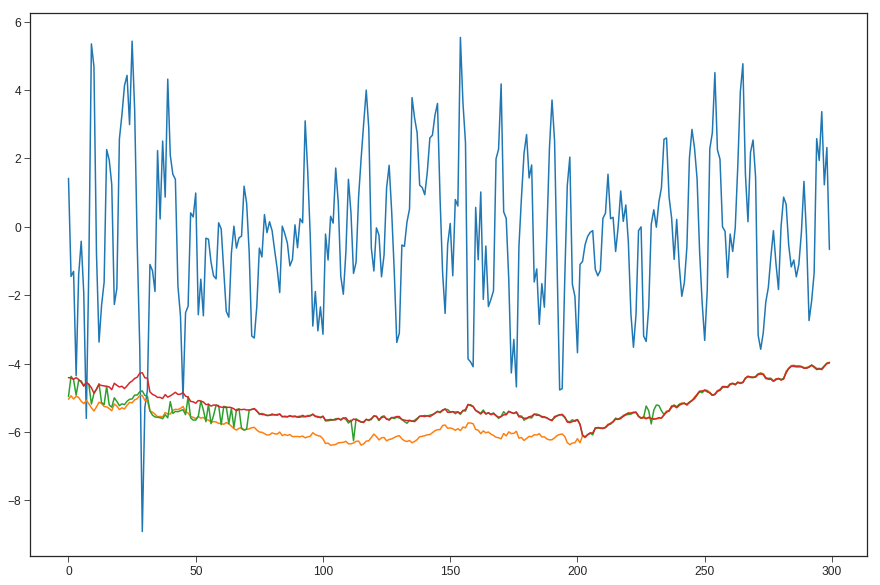

In [772]:
plt.figure(figsize=(15,10))
plt.plot(vals.transpose())

In [775]:
v = vals.T

# d[:,]
loss_= np.abs(v[v[:,0]<0,:])
print(loss_[(loss_[:,0] - loss_[:,1])>0,1].shape)
print(loss_[(loss_[:,0] - loss_[:,2])>0,2].shape)
print(loss_[(loss_[:,0] - loss_[:,3])>0,3].shape)
print('expected:', (1-alpha) * 300)
print(loss_)


(3,)
(3,)
(5,)
expected: 9.000000000000007
[[ 1.45        4.93983254  4.37012116  4.41821559]
 [ 1.3         5.03329642  4.47296776  4.45658063]
 [ 4.35        4.95266512  4.91899907  4.40859641]
 [ 1.39        4.98740471  4.48984398  4.46304441]
 [ 0.42        5.10095356  4.50702997  4.54043666]
 [ 1.94        5.16923069  4.64648477  4.65680788]
 [ 5.6         5.07311221  4.55621152  4.54874115]
 [ 1.12        5.1754665   4.60549833  4.60480855]
 [ 0.79        5.26429654  4.74150308  4.74833861]
 [ 3.37        5.12690711  4.58570924  4.61145139]
 [ 2.29        5.16411335  5.13793676  4.63792857]
 [ 1.62        5.25272197  5.19624289  4.65017274]
 [ 2.27        5.17753939  4.99739191  4.57248676]
 [ 1.8         5.23952362  5.10365236  4.63221953]
 [ 0.51        5.0247677   4.91636017  4.39646258]
 [ 3.52        4.93149807  4.82287745  4.27916634]
 [ 8.91        4.92887499  4.79678423  4.26564288]
 [ 5.28        5.07378322  4.92704714  4.41411195]
 [ 4.78        5.0810972   4.9491469   

[ 0.65135397  0.13094735  0.21769868]
[ -1.74372070e-05   7.32420318e-03  -6.07433535e-03]
-0.000374647553552
[ 0.00733592]
0.00992564040035
-0.000374647553552
7.51696295104e-06
(10000,)


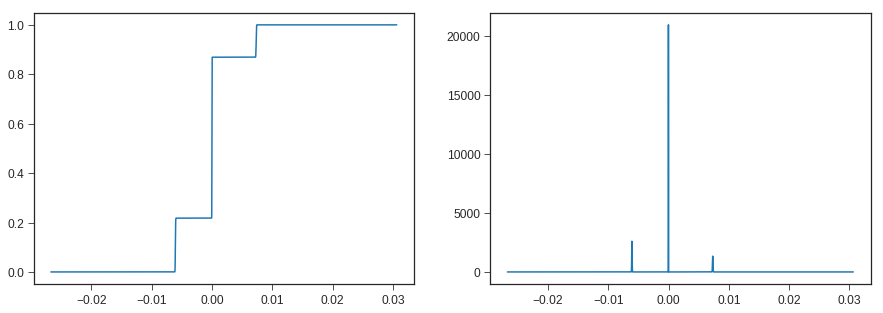

In [18]:
alpha = 0.95
ws = gmm.weights_
theta = list(zip(gmm.means_.flatten(), gmm.covariances_.flatten()))
cdfs = [norm(m,s).cdf for m, s in  theta]
pdfs = [norm(m,s).pdf for m, s in  theta]
f_mixture_cdf = weighted_funcs(ws, cdfs)
fprime = weighted_funcs(ws, pdfs)
f = quantile_eq(f_mixture_cdf, alpha)

print(gmm.weights_)
print(gmm.means_.flatten())
print(np.dot(ws,gmm.means_)[0])
print(newton(f, max(gmm.means_),fprime=fprime))
# print('newton dot: ', newton(f, np.dot(ws,gmm.means_)[0],fprime=fprime))

# k = 0
# print(norm(theta[k][0], theta[k][1]).ppf(0.995))
# print(norm(theta[k][0], theta[k][1]).ppf(0.95))

N = 1000
# print(np.percentile(norm(theta[k][0], theta[k][1]).rvs(N), alpha*100))
# print(f_mixture_cdf.ppf(0.995))
print(np.percentile(gmm.sample(N)[0], alpha*100))

mu = np.dot(ws, gmm.means_.flatten())
sig2 = np.dot(ws**2, gmm.covariances_.flatten())

x = np.linspace(mu - 100 * sig2, mu + 100 * sig2, 1000)
x = np.linspace(min(X), max(X), 10000)
print(mu)
print(sig2)
print(x.shape)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x, f_mixture_cdf(x))
plt.subplot(1,2,2)
plt.plot(x, fprime(x))